
Nesse exercício vamos trabalhar com algumas ferramentas que podemos usar no Keras para melhorar nossas redes neurais.

Sabemos que para banco de dados de imagens, as redes convoluncionais são mais eficiente, o que fazer fazer aqui é criar uma rede relativamente pequena, totalmente Densa e Feed foward, sem nenhuma convolução.

Será que conseguimos uma acuracia razoável fazendo algumas modificações na rede sem adicionar nenhum camada de convolução?

Vamos começar importando as bibliotecas:


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

### O Banco de dados que usaremos, é o **cifar10**, um banco de dados de imagens divididos em 10 classes:

airplane 0

automobile 1

bird 2

cat 3

deer 4

dog 5

frog 6

horse 7

ship 8

truck 9

In [ ]:
def dic_classes(pred):
  dicionario = {0: "Avião",
           1: "Automóvel",
           2: "Pássaro",
           3: "Gato",
           4: "Veado",
           5: "Cachorro",
           6: "Sapo",
           7: "Cavalo",
           8: "Navio/Barco",
           9: "Caminhão"}
  return dicionario[(pred)]

In [ ]:
# criando nossos dados de treino e teste

(Xtreino, ytreino), (Xteste, yteste) = tf.keras.datasets.cifar10.load_data()

In [ ]:
amostra_treino = np.random.choice(range(len(Xtreino)), size = 30000, replace = False)
amostra_teste = np.random.choice(range(len(Xteste)), size = 3000, replace= False)

In [ ]:
Xtreino = Xtreino[amostra_treino,:]
ytreino = ytreino[amostra_treino,:]

Xteste = Xteste[amostra_teste,:]
yteste = yteste[amostra_teste,:]

In [ ]:
Xtreino.shape, ytreino.shape, Xteste.shape, yteste.shape

((30000, 32, 32, 3), (30000, 1), (3000, 32, 32, 3), (3000, 1))

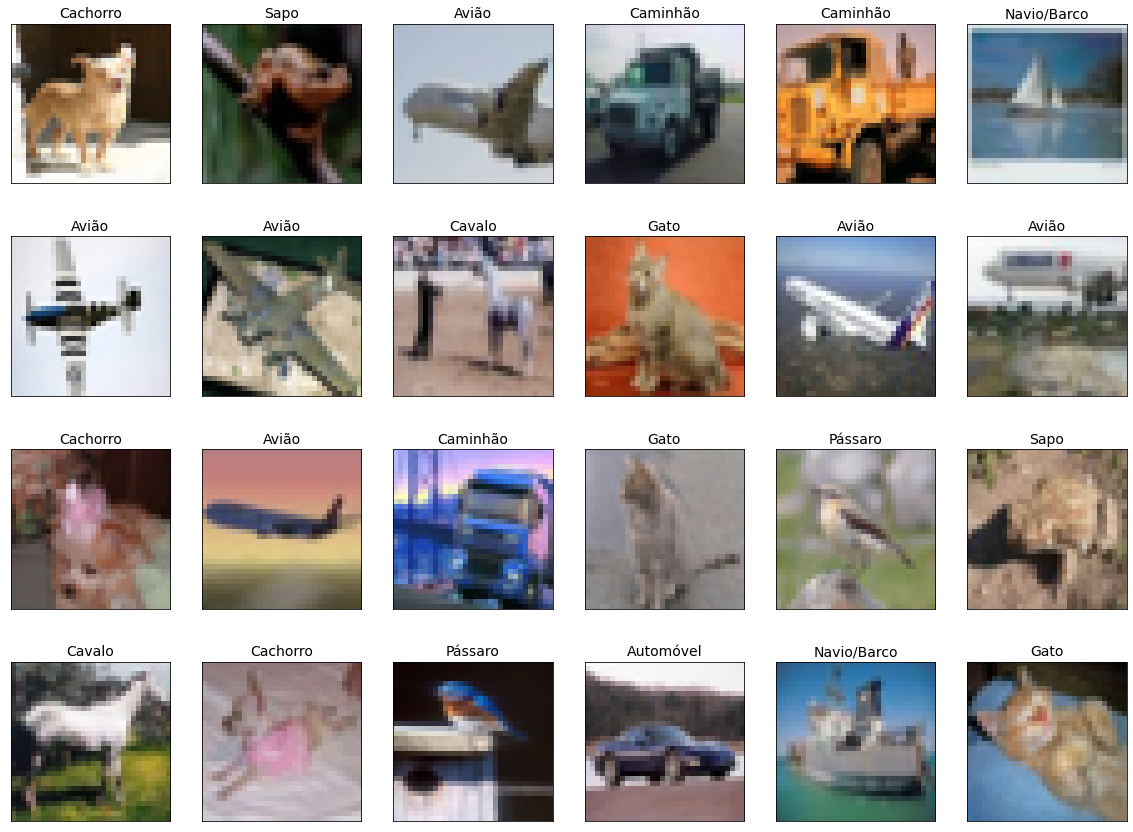

In [ ]:
random_idx = np.random.randint(0,20000, size = 24)

plt.figure(figsize=[20,15])
for i in range(len(random_idx)):
    idx_i = random_idx[i]
    xval = Xtreino[idx_i, :]
    yval = ytreino[idx_i]
    plt.subplot(4,6,i+1)
    plt.imshow(xval, cmap = plt.cm.Blues_r)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(dic_classes(yval[0])), fontsize = 14)
plt.show()

Aleatóriamente como temos 10 classes, nossa chance de acertar seria de 10%, então vamos criar algumas redes neurais e ver como se saem em relação a isso.

Vamos começar com bem simples, sem nenhuma normalização, usando AdaGrad (otimizador que ajusta o learning rate a cada passo), 50 épocas e 75 de batch size:

In [ ]:
# para nossa classificação faremos inicialmente um OHE.

ytreino1 = keras.utils.to_categorical(ytreino)
yteste1 = keras.utils.to_categorical(yteste)

In [ ]:
# criando o primeiro modelo

modelo1 = keras.Sequential()

modelo1.add(layers.Dense(64, input_shape=(32,32,3)))
modelo1.add(layers.Dense(64))
modelo1.add(layers.Dense(64))
modelo1.add(layers.Dense(64))
modelo1.add(layers.Dense(64))
modelo1.add(layers.Dense(64))
modelo1.add(layers.Flatten())
modelo1.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
modelo1.add(layers.Dense(10, activation='softmax'))

opt = keras.optimizers.Adagrad()
modelo1.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
modelo1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32, 32, 64)        256       
_________________________________________________________________
dense_1 (Dense)              (None, 32, 32, 64)        4160      
_________________________________________________________________
dense_2 (Dense)              (None, 32, 32, 64)        4160      
_________________________________________________________________
dense_3 (Dense)              (None, 32, 32, 64)        4160      
_________________________________________________________________
dense_4 (Dense)              (None, 32, 32, 64)        4160      
_________________________________________________________________
dense_5 (Dense)              (None, 32, 32, 64)        4160      
_________________________________________________________________
flatten (Flatten)            (None, 65536)             0

In [ ]:
import datetime
!rm -rf ./logs/
log_dir = "logs/fit/" + (datetime.datetime.now() + datetime.timedelta(hours=-3)).strftime("%Y%m%d-%H%M%S")
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)


In [ ]:
modelo1.fit(Xtreino,
          ytreino1,
          epochs=50,
          batch_size=75,
          validation_data=(Xteste, yteste1),
          callbacks=[tb_callback]
          )

Epoch 1/50
400/400 [==============================] - 7s 15ms/step - loss: 16.6586 - accuracy: 0.1108 - val_loss: 2.2932 - val_accuracy: 0.1133
Epoch 2/50
400/400 [==============================] - 5s 13ms/step - loss: 2.3071 - accuracy: 0.1112 - val_loss: 2.2823 - val_accuracy: 0.1250
Epoch 3/50
400/400 [==============================] - 5s 13ms/step - loss: 2.2875 - accuracy: 0.1176 - val_loss: 2.2796 - val_accuracy: 0.1263
Epoch 4/50
400/400 [==============================] - 5s 13ms/step - loss: 2.2819 - accuracy: 0.1235 - val_loss: 2.2670 - val_accuracy: 0.1380
Epoch 5/50
400/400 [==============================] - 5s 13ms/step - loss: 2.2867 - accuracy: 0.1192 - val_loss: 2.2954 - val_accuracy: 0.1110
Epoch 6/50
400/400 [==============================] - 5s 13ms/step - loss: 2.2805 - accuracy: 0.1213 - val_loss: 2.2705 - val_accuracy: 0.1433
Epoch 7/50
400/400 [==============================] - 5s 13ms/step - loss: 2.2686 - accuracy: 0.1337 - val_loss: 2.2845 - val_accuracy: 0.123

### Note que mesmo nossa rede tendo 8 milhões de parâmetros, a acurácia nos dados de validação é de apenas 30%, vamos tentar melhorar esse número, mudando o otimizador para o Adadelta, que é um Adagrad mais robusto, aumentando as épocas para 100 e o batch size para 128:

In [ ]:
modelo2 = keras.Sequential()

modelo2.add(layers.Dense(64, input_shape=(32,32,3)))
modelo2.add(layers.Dense(64))
modelo2.add(layers.Dense(64))
modelo2.add(layers.Dense(64))
modelo2.add(layers.Dense(64))
modelo2.add(layers.Dense(64))
modelo2.add(layers.Flatten())
modelo2.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
modelo2.add(layers.Dense(10, activation='softmax'))

opt = keras.optimizers.Adadelta()
modelo2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
modelo2.fit(Xtreino,
          ytreino1,
          epochs=100,
          batch_size=128,
          validation_data=(Xteste, yteste1),
          callbacks=[tb_callback]
          )

Epoch 1/100
235/235 [==============================] - 7s 26ms/step - loss: 19.3882 - accuracy: 0.1772 - val_loss: 14.2302 - val_accuracy: 0.1960
Epoch 2/100
235/235 [==============================] - 5s 23ms/step - loss: 11.9633 - accuracy: 0.2189 - val_loss: 11.4466 - val_accuracy: 0.2183
Epoch 3/100
235/235 [==============================] - 5s 23ms/step - loss: 9.6732 - accuracy: 0.2302 - val_loss: 9.2068 - val_accuracy: 0.2260
Epoch 4/100
235/235 [==============================] - 5s 23ms/step - loss: 8.2192 - accuracy: 0.2429 - val_loss: 7.9485 - val_accuracy: 0.2457
Epoch 5/100
235/235 [==============================] - 5s 23ms/step - loss: 7.3043 - accuracy: 0.2510 - val_loss: 8.1841 - val_accuracy: 0.2280
Epoch 6/100
235/235 [==============================] - 5s 23ms/step - loss: 6.6412 - accuracy: 0.2562 - val_loss: 7.4440 - val_accuracy: 0.2313
Epoch 7/100
235/235 [==============================] - 5s 23ms/step - loss: 6.1024 - accuracy: 0.2642 - val_loss: 6.4083 - val_accur

#### Conseguimos uma melhoria na nossa acurácia, aumentamos de 30% para 36%, agora vamos criar outro modelo, acrescentando regularizações L2 em duas camadas:

In [ ]:
modelo3 = keras.Sequential()

modelo3.add(layers.Dense(64, input_shape=(32,32,3)))
modelo3.add(layers.Dense(64,
    activity_regularizer=regularizers.l2(1e-5)))
modelo3.add(layers.Dense(64))
modelo3.add(layers.Dense(64))
modelo3.add(layers.Dense(64))
modelo3.add(layers.Dense(64))
modelo3.add(layers.Dense(64, activity_regularizer=regularizers.l2(1e-5)))
modelo3.add(layers.Flatten())
modelo3.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
modelo3.add(layers.Dense(10, activation='softmax'))

opt = keras.optimizers.Adadelta()
modelo3.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
modelo3.fit(Xtreino,
          ytreino1,
          epochs=100,
          batch_size=128,
          validation_data=(Xteste, yteste1),
          callbacks=[tb_callback]
          )

Epoch 1/100
235/235 [==============================] - 9s 34ms/step - loss: 5066.8413 - accuracy: 0.1612 - val_loss: 4737.0483 - val_accuracy: 0.1943
Epoch 2/100
235/235 [==============================] - 7s 31ms/step - loss: 4176.2163 - accuracy: 0.2013 - val_loss: 3901.2183 - val_accuracy: 0.2073
Epoch 3/100
235/235 [==============================] - 7s 31ms/step - loss: 3435.6235 - accuracy: 0.2205 - val_loss: 3205.4241 - val_accuracy: 0.2120
Epoch 4/100
235/235 [==============================] - 7s 31ms/step - loss: 2818.0210 - accuracy: 0.2354 - val_loss: 2621.8708 - val_accuracy: 0.2153
Epoch 5/100
235/235 [==============================] - 8s 32ms/step - loss: 2294.9150 - accuracy: 0.2447 - val_loss: 2121.9819 - val_accuracy: 0.2273
Epoch 6/100
235/235 [==============================] - 7s 31ms/step - loss: 1843.9639 - accuracy: 0.2560 - val_loss: 1693.1998 - val_accuracy: 0.2437
Epoch 7/100
235/235 [==============================] - 7s 31ms/step - loss: 1474.9138 - accuracy: 0.

#### Com a regularização, conseguimos um aumento significativo para 50% de acurácia nos dados de validação, vamos olhar o tensorboard:

#### Sabemos que aumentando o número de épocas, vamos aumentar a acurácia nos dados de treino, porém, até quando conseguimos aumentar também a acurácia nos dados de validação? Poderiamos fazer vários testes, mudando a época para 200, 300, 400, e depois analisar os resultados, porém, vamos fazer diferente:

#### Vamos criar um earlystopping, controlando o valor da acurácia nos dados de validação, e assim, conseguiremos um melhor resultado, sem risco de overfiting.

In [ ]:
stopper = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=10, verbose=2, mode ='max'
)

In [ ]:
modelo4 = keras.Sequential()

modelo4.add(layers.Dense(64, input_shape=(32,32,3)))
modelo4.add(layers.Dense(64,
    activity_regularizer=regularizers.l2(1e-5)))
modelo4.add(layers.Dense(64))
modelo4.add(layers.Dense(64))
modelo4.add(layers.Dense(64))
modelo4.add(layers.Dense(64))
modelo4.add(layers.Dense(64, activity_regularizer=regularizers.l2(1e-5)))
modelo4.add(layers.Flatten())
modelo4.add(layers.Dense(128, activation='relu', kernel_initializer='he_uniform'))
modelo4.add(layers.Dense(10, activation='softmax'))

opt = keras.optimizers.Adadelta()
modelo4.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
modelo4.fit(Xtreino,
          ytreino1,
          epochs=500,
          batch_size=128,
          validation_data=(Xteste, yteste1),
          callbacks=[stopper]
          )

Epoch 1/500
235/235 [==============================] - 8s 32ms/step - loss: 1489.9825 - accuracy: 0.1741 - val_loss: 1429.8810 - val_accuracy: 0.2080
Epoch 2/500
235/235 [==============================] - 7s 30ms/step - loss: 1299.9542 - accuracy: 0.2263 - val_loss: 1255.5535 - val_accuracy: 0.2377
Epoch 3/500
235/235 [==============================] - 7s 30ms/step - loss: 1146.7490 - accuracy: 0.2449 - val_loss: 1112.7948 - val_accuracy: 0.2520
Epoch 4/500
235/235 [==============================] - 7s 31ms/step - loss: 1020.6227 - accuracy: 0.2627 - val_loss: 994.3812 - val_accuracy: 0.2617
Epoch 5/500
235/235 [==============================] - 7s 31ms/step - loss: 915.6635 - accuracy: 0.2745 - val_loss: 895.4313 - val_accuracy: 0.2680
Epoch 6/500
235/235 [==============================] - 7s 31ms/step - loss: 827.0817 - accuracy: 0.2906 - val_loss: 811.0622 - val_accuracy: 0.2820
Epoch 7/500
235/235 [==============================] - 7s 31ms/step - loss: 750.8990 - accuracy: 0.3095 -

#### Com 108 épocas, conseguimos estabilizar nossa acurácia nos dados de validação, com o valor praticamente igual ao do modelo anterior: 51%.



## Finalizamos aqui nosso exercício, conseguindo bons resultados para o desejado, vamos analisar um pouco algumas imagens, com a nossa predição

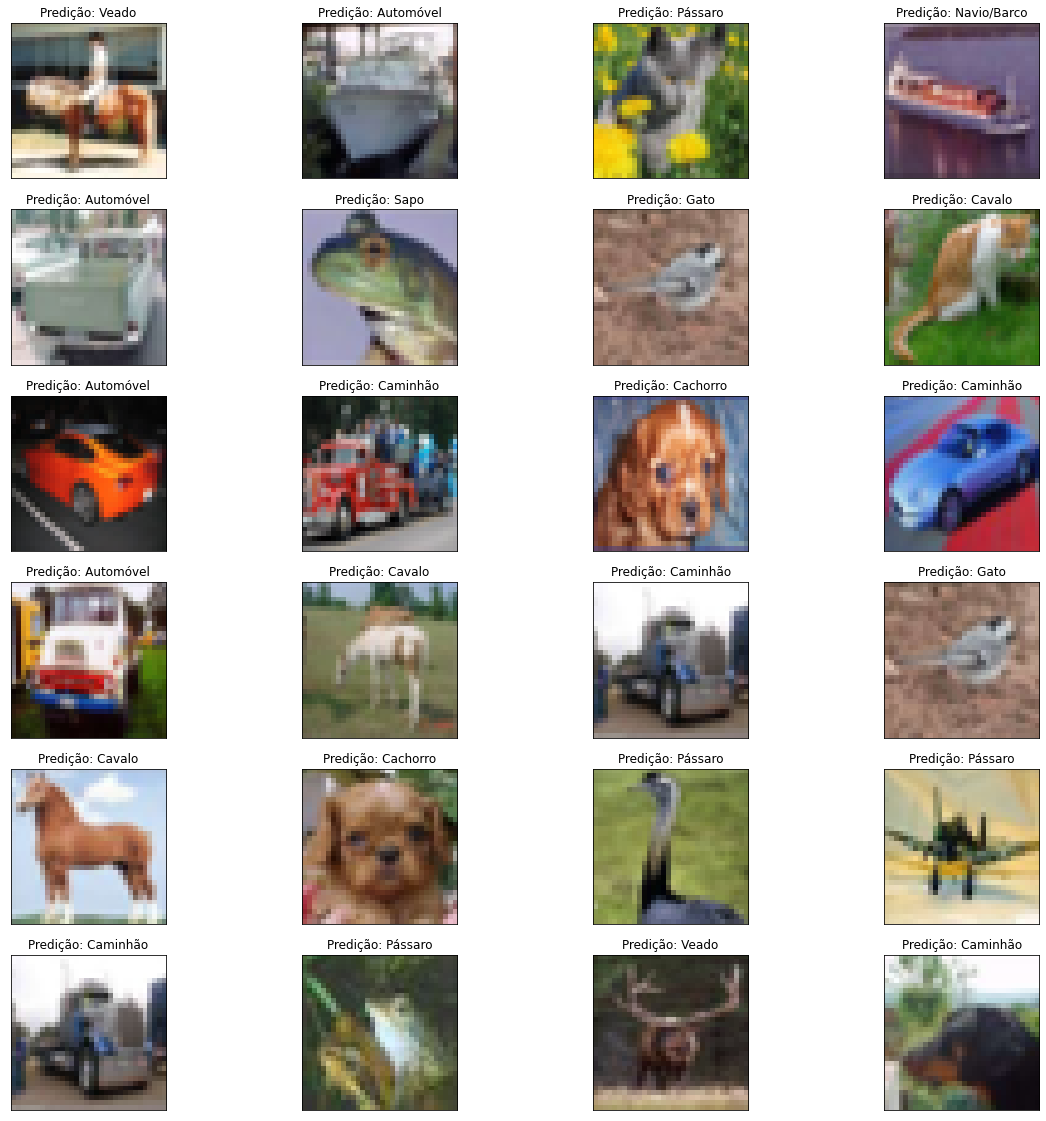

In [ ]:
random_idx = np.random.randint(0,2000, size = 24)

plt.figure(figsize=[20,20])
for i in range(len(random_idx)):
    idx_i = random_idx[i]
    xval = Xteste[idx_i]
    pred = modelo4.predict(tf.expand_dims(xval, 0))
    plt.subplot(6,4,i+1)
    plt.imshow(xval, cmap = plt.cm.Blues_r)
    plt.xticks([])
    plt.yticks([])
    plt.title("Predição: " + str(dic_classes(int(np.argmax(pred)))))
plt.show()

Como esperado, mais ou menos 50% de acerto, Lembrando que nosso objetivo principal foi cumprindo, usar ferramentas, como regularização, escolha de otimizares, Gridsearch com épocas e batch size.

Finalizamos assim o notebook e o exercício.